In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def generate_and_plot_random_graph(num_nodes, num_edges):
    # Create an empty graph
    G = nx.Graph()

    # Generate random edges until the desired number of edges is reached
    while G.number_of_edges() < num_edges:
        # Generate two random nodes and add an edge between them
        node1 = random.randint(0, num_nodes - 1)
        node2 = random.randint(0, num_nodes - 1)
        if node1 != node2:
            G.add_edge(node1, node2)

    # Plot the graph
    pos = nx.spring_layout(G, seed=42)  # Seed for reproducibility
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200)
    plt.title("Random Graph")
    plt.show()

    return G

if __name__ == "__main__":
    import random
    num_nodes = 10  # Change this to the desired number of nodes
    num_edges = 15  # Change this to the desired number of edges
    G = generate_and_plot_random_graph(num_nodes, num_edges)


In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
node = [1,2,3,4,5]
edge = [(1,2),(1,3),(1,4),(2,3),(3,4),(2,5)]
G.add_nodes_from(node)
G.add_edges_from(edge)

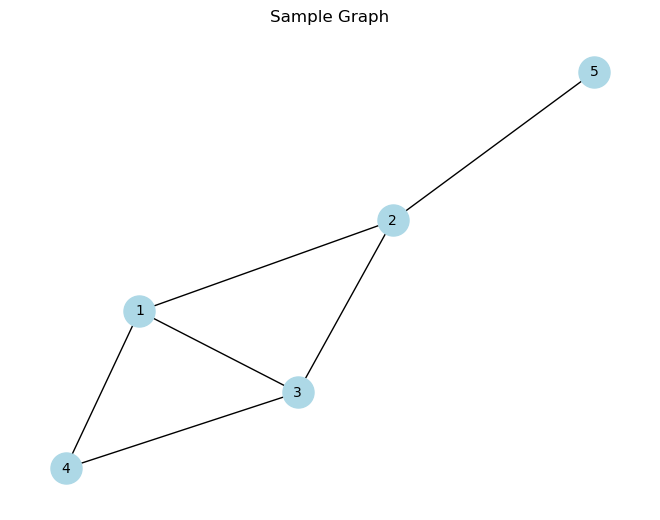

In [2]:
# Define the layout (how the nodes are positioned)
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black')
plt.title("Sample Graph")
plt.show()

# Function for SRW on G(d)

In [3]:
import random
import queue

# Functions for SRW on G(d)

# A state is a graph with d nodes. We repersent it as a nx.Graph(). Noted the differnt of currect_state, walking_state, and next_state.

# State operation

def remove_random_node(current_state):
    nodes = list(current_state.nodes())
    node_removed = random.choice(nodes)
    walking_state = current_state.copy()
    walking_state.remove_node(node_removed)
    return walking_state, node_removed

# find possible node can be added for each node in a state
def find_all_possible_new_node(current_state):
    nodes = list(current_state.nodes())
    candidate_nodes_dict = {}
    for node in nodes:
        # neighbors is a list
        neighbors = list(G.neighbors(node))
        candidate_nodes_dict[node] = [x for x in neighbors if x not in nodes]
    return candidate_nodes_dict

# return all possible walking state
def find_all_possible_walking_state(current_state):

    nodes = list(current_state.nodes())
    possible_walking_states = []

    if len(nodes) == 1:
        possible_walking_states.append(current_state)
        return possible_walking_states

    for node in nodes:
        walking_state = current_state.copy()
        walking_state.remove_node(node)
        possible_walking_states.append(walking_state)
    return possible_walking_states

# check if the walking state any disconnection
def subgraph_counting(walking_state):
    subgraph_listing = list(nx.connected_components(walking_state))
    return subgraph_listing, len(subgraph_listing)

# just validation, doesn't return a new state!
def walking_validation(walking_state, newnode, newedges, degree_req = 0):
    
    if degree_req != 0:
        if len(newedges) < degree_req:
            return False
    
    checking_state = walking_state.copy()
    checking_state.add_node(newnode)
    checking_state.add_edges_from(newedges)
    
    if len(list(nx.connected_components(checking_state))) == 1:
        return newedges
    else:
        return False


In [6]:
def extract_valid_new_state(current_state, G):

    candidate_nodes_dict = find_all_possible_new_node(current_state)

    possible_walking_states = find_all_possible_walking_state(current_state)

    drop_add_list, edges_list = [], []

    for walking_state in possible_walking_states:
        if len(possible_walking_states) == 1:
            missing_node = list(walking_state.nodes())[0]
            remining_nodes = list(walking_state.nodes())
        else:
            missing_node = (set(current_state.nodes()) - set(walking_state.nodes())).pop()
            remining_nodes = list(walking_state.nodes())
        checked_candidate = []
        for node_remained in remining_nodes:
            for newnode in candidate_nodes_dict[node_remained]:
                    newedges = [(newnode, v) for newnode, v in G.edges(newnode) if v in walking_state]
                    if newnode not in checked_candidate:
                        checked_candidate.append(newnode)
                        if walking_validation(walking_state, newnode, newedges):
                            drop_add_list.append((missing_node, newnode))
                            edges_list.append(newedges)

    return drop_add_list, edges_list


In [75]:
current_state = nx.Graph()
node = [2]
edge = []
current_state.add_nodes_from(node)
current_state.add_edges_from(edge)

In [76]:
extract_valid_new_state(current_state, G)

([(2, 1), (2, 3), (2, 5)], [[(1, 2)], [(3, 2)], [(5, 2)]])

# Functions for line #3

In [126]:
import queue

# Functions for line #3, walk l step to get the initial state X(l)

# We have consider use a nx.Graph() represent the X(l), that contain information about the edge (H) connecting different state.
# However, we found that the links between states are prevented and are not nessary information, what important is the squence.
# We can use only the list to store the X(l) instead of nx.Graph().
# So we will have a list of nx.Graph() instead of graph of graph for X(l).
# In that sence, for line #6, we don't need to reconstruct graphlet by refering to the original G. But we can reconstruct the graphlet by only refering to X(l).

# Here are function for intializing first state X1. We first randomly pick a node and perfrom random walk to find d distinct node for X1,
# there could be repeat node during the random walk resulting not enough distinct elements, so it keep walking until the last d node are all distinct.
# We observed that this method will not yeild a uniform selection for X1 on G(d). However, the paper claim that as the estimation 
# will converage despite any intial X1 and even X(l), Marco suggested that non-uniform selection is not a problem 
# and our uniform selection methods via combination was not performed.

def SingleNode_SRW(node, G, previous_node=False):
    # Here you can see a complete non-backtracking(NB) random walk intialization logic. You will not see a single NB function for 
    # extented markov chain because sperated function can help us perform two type of SRW (SRW vs NBSRW) for performance comparsion, but here I write them tgt in 
    # single function SingleNode_SRW because it imporve the efficiency of generating X1 and we don't need comparsion for SRW and NBSRW here.
    neighbors = list(G.neighbors(node))
    if len(neighbors) == 1:
        return neighbors[0]
    if previous_node:
        neighbors.remove(previous_node)
    random_neighbor = random.choice(neighbors)
    return random_neighbor

# Initializing X1 (the first state with d nodes) for the initial state X(l), where l = k - d + 1.
def initialize_X1(G, d):
    if d > len(list(G.nodes())):
        raise ValueError("Parameter must be lower than the number of nodes in original graph.")
    x1_node = []
    # initailize node via sigle node simple random walk
    node = random.choice(list(G.nodes()))
    x1_node.append(node)
    while True:
        node = SingleNode_SRW(node, G)
        x1_node.append(node)
        if len(set(x1_node[-d:])) == d:
            break
    x1 = nx.Graph()
    x1.add_nodes_from(x1_node[-d:])
    for node in x1_node[-d:]:
        edges = [(newnode, v) for newnode, v in G.edges(node) if v in x1]
        x1.add_edges_from(edges)

    return x1


# Here are function for initialize X(l). Since we now have X1, we can generate X(l) via SRW on G(d).
# queue applied

# This function integrate SRW and NBSRW controlled by if the pervious_transfor provided.
def SRW(X, G, pervious_transfor=False):

    state = X.copy()
    srw = extract_valid_new_state(state, G)

    if pervious_transfor:

        a, b = pervious_transfor
        node_operation = (b, a)
        i = srw[0].index(node_operation)
        srw[0].pop(i)
        edges = srw[1].pop(i)

        # be careful that if degree = 1 for current state, walk back to pervous state.
        if len(srw[0]) == 0:

            state.remove_node(node_operation[0])
            state.add_node(node_operation[1])
            if len(list(state.nodes())) > 1:
                state.add_edges_from(edges)

            return state, node_operation
    
    path = random.randint(0, len(srw[0])-1)
    node_operation = srw[0][path]
    edges = srw[1][path]
    state.remove_node(node_operation[0])
    state.add_node(node_operation[1])
    if len(list(state.nodes())) > 1:
        state.add_edges_from(edges)

    return state, node_operation

def gernerate_Xl_with_X1(X1, G, k, X=nx.Graph()):
    d = len(list(X1.nodes()))
    # The length of X(l)
    l = k - d
    X = X1.copy()
    Xl = queue.Queue()
    Xl.put(X)
    pervious_transfor=False
    for _ in range(l):
        # same as X1 intialization, it is NB intialization, pervious_transfor will be provided onec walk.
        X, pervious_transfor = SRW(X, G, pervious_transfor)
        Xl.put(X)
    return Xl



In [132]:
x1 = initialize_X1(G, 2)
x1.nodes()

NodeView((5, 2))

In [133]:

xl = gernerate_Xl_with_X1(x1, G, k=5)

In [134]:
while not xl.empty():
    item = xl.get()
    print(item.nodes())

[5, 2]
[2, 3]
[3, 4]
[4, 1]
